In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

## Load Data

In [ ]:
gene_assignment = pd.read_msgpack('NodeGeneResults.msg')

In [82]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t', index_col='gene_id'
)
idbase_to_id = {g.split('.')[0]: g for g in gene_meta.index}

### Motif Enrichment

In [2]:
motif_gene_anno = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/MotifClustering/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.with_motif_group.199.csv', 
    index_col=0
)
tf_class = pd.read_csv('/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv')
tf_class.head()

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
0,1.1.1.1.1,c-Jun,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000052684
1,1.1.1.1.2,JunB,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,"ENSMUSG00000052837,ENSMUSG00000052926"
2,1.1.1.1.3,JunD,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,Jun,ENSMUSG00000071076
3,1.1.1.2.1,NFE2,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000058794
4,1.1.1.2.2,NFE2L1,Basic domains,Basic leucine zipper factors (bZIP),Jun-related,NFE2,ENSMUSG00000038615


In [3]:
for tf_col in ['Class', 'Family', 'SubFamily']:
    gene_class_map = {}
    for _, (class_name, genes) in tf_class[[tf_col, 'EnsemblID']].iterrows():
        if isinstance(genes, float):
            continue
        for gene in genes.split(','):
            gene_class_map[gene] = class_name
    
    motif_gene_anno[tf_col] = motif_gene_anno['gene_ids'].apply(lambda i: gene_class_map.get(i.split('.')[0], ''))
motif_gene_anno.head()

,motif_name,motif_genes,gene_ids,gene_names,motif_group,Class,Family,SubFamily
motif_uid,,,,,,,,
MA0006.1,Ahr::Arnt,"Ahr,Arnt","ENSMUSG00000019256.17,ENSMUSG00000015522.18","Ahr,Arnt",MotifGroup178,Basic helix-loop-helix factors (bHLH),PAS,PAS-AHR
MA0854.1,Alx1,Alx1,ENSMUSG00000036602.14,Alx1,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0634.1,ALX3,ALX3,ENSMUSG00000014603.3,Alx3,MotifGroup3,Homeo domain factors,Paired-related HD,TPRX
MA0853.1,Alx4,Alx4,ENSMUSG00000040310.12,Alx4,MotifGroup3,Homeo domain factors,Paired-related HD,ALX
MA0007.3,Ar,Ar,ENSMUSG00000046532.8,Ar,MotifGroup32,Nuclear receptors with C4 zinc fingers,Steroid hormone receptors,GR-like(NR3C)


In [4]:
lgp_cutoff = 10
odds_cutoff = 1

data = pd.read_msgpack('NodeMotifEnrichment.total_DMR.msg')
data = data[(data['-lgp'] > lgp_cutoff) & (data['log2odds'].abs() > odds_cutoff)].copy()
data = pd.concat([motif_gene_anno.reindex(data.index), data], axis=1)
data['SubFamily'] = data.apply(lambda i: i['SubFamily'] if isinstance(
    i['SubFamily'], str) else i['Family'],
                               axis=1)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Tree

In [5]:
linkage = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.csv',
    index_col=0)
linkage_label = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.linkage.orders.txt',
    header=None, index_col=0).index
dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)

## Plot function

### Normal

In [6]:
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from scipy.cluster.hierarchy import dendrogram


def straight_branch(ax, a, b, plot_kws):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    branch_x = [a_x, bx, bx]
    branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram(linkage_df,
                    labels_list,
                    dendro_kws=None,
                    ax=None,
                    branch_type='straight',
                    plot_node_id=False,
                    plot_kws=None,
                    node_hue=None,
                    node_hue_norm=None,
                    palette='viridis',  # shared by both line and node hue
                    node_size=None,
                    node_size_norm=None,
                    line_hue=None,
                    line_hue_norm=None,
                    sizes=None,
                    size=30,
                    linewidth=1,
                    color=None):
    if plot_kws is None:
        plot_kws = {}

    _dendro_kws = dict(no_plot=True)
    if dendro_kws is not None:
        _dendro_kws.update(dendro_kws)
    # all we need is the leaves order from dendrogram,
    # bellow we recalculate the node position to match the node id,
    # so we can control each node
    dendro = dendrogram(linkage_df, labels=labels_list, **_dendro_kws)
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)),)
    else:
        node_hue = {}

        def node_cmap(_):
            raise
    node_colors = {node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
                   for node in node_pos.keys()}

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values),
                                   vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm)) # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise
    node_sizes = {node: node_smap(node_size[node]) if (node in node_size) else nan_size
                  for node in node_pos.keys()}

    for node_id, (node_x, node_y) in node_pos.items():
        ax.scatter(node_x, node_y, s=node_sizes[node_id], c=node_colors[node_id], zorder=3)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise
    line_colors = {node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
                   for node in node_pos.keys()}

    ymax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        ymax = max(ymax, node_y)
        # plot node id text
        if plot_node_id:
            if node_id >= n_leaves:
                ax.text(node_x, node_y, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')
            else:
                ax.text(node_x, -0.01, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]

            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth))

            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth))

    ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    return node_pos, dendro


def plot_parsimony_data(data, ax, hue_norm, palette):
    sns.barplot(data=data, x='index', y='tree',
                label='tree', ax=ax,
                color='steelblue', alpha=0.3)
    sns.scatterplot(data=data, x='index', y='raw',
                    label='raw', ax=ax, color='lightgray',
                    hue='tree', hue_norm=hue_norm, palette=palette,
                    alpha=0.7, linewidth=1, legend=None)
    return


def plot_colorbar(cax, cmap, cnorm, hue_norm, linewidth=0.5):
    if isinstance(cmap, str):
        cmap = get_cmap(cmap)

    colorbar = ColorbarBase(cax, cmap=cmap, norm=cnorm,
                            orientation='vertical', extend='both')
    colorbar_ticks = [hue_norm[0], sum(hue_norm) / 2, hue_norm[1]]
    # TODO automatic ticklabel format, auto sci-format, float trim etc
    colorbar_ticklabels = list(map(lambda i: f'{i:.1f}', colorbar_ticks))
    colorbar.set_ticks(colorbar_ticks)
    colorbar.set_ticklabels(colorbar_ticklabels)
    colorbar.outline.set_linewidth(linewidth)
    colorbar.ax.tick_params(size=1, pad=1, width=linewidth, length=0.3)
    return cax


### Polar

In [7]:
import seaborn as sns
from matplotlib.cm import get_cmap
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from scipy.cluster.hierarchy import dendrogram
import numpy as np

def straight_branch_polar(ax, a, b, plot_kws):
    """Draw link line between a and b"""
    a_x, ay = a
    bx, by = b
    
    a_x = 2 * np.pi * a_x / (77+1)
    bx = 2 * np.pi * bx / (77+1)
    
    branch_x = [a_x, bx, bx]
    branch_y = [ay, ay, by]
    if plot_kws is None:
        plot_kws = {}
    return ax.plot(branch_x, branch_y, **plot_kws)


def plot_dendrogram_polar(linkage_df,
                    labels_list,
                    dendro_kws=None,
                    ax=None,
                    branch_type='straight',
                    plot_node_id=False,
                    plot_kws=None,
                    node_hue=None,
                    node_hue_norm=None,
                    palette='viridis',  # shared by both line and node hue
                    node_size=None,
                    node_size_norm=None,
                    line_hue=None,
                    line_hue_norm=None,
                    sizes=None,
                    size=30,
                    linewidth=1,
                    color=None):
    if plot_kws is None:
        plot_kws = {}

    _dendro_kws = dict(no_plot=True)
    if dendro_kws is not None:
        _dendro_kws.update(dendro_kws)
    # all we need is the leaves order from dendrogram,
    # bellow we recalculate the node position to match the node id,
    # so we can control each node
    dendro = dendrogram(linkage_df, labels=labels_list, **_dendro_kws)
    n_leaves = len(dendro['leaves'])

    node_pos = {}  # all node including singleton and non-singleton
    for leaf_x, leaf in enumerate(dendro['leaves']):
        node_pos[int(leaf)] = (leaf_x, 0)

    direct_link_map = {}  # node linkage, keys only contain non-singleton
    for i, (left, right, height, _) in linkage_df.iterrows():
        node_id = int(i + linkage_df.shape[0] + 1)
        left = int(left)
        right = int(right)
        node_x = (node_pos[left][0] + node_pos[right][0]) / 2
        node_pos[node_id] = [node_x, height]
        direct_link_map[node_id] = [int(left), int(right)]

    if branch_type == 'straight':
        branch_plot_function = straight_branch_polar
    else:
        raise

    # node colors
    nan_color = '#D3D3D3' if color is None else color
    if node_hue is not None:
        if node_hue_norm is None:
            values = node_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(node_hue_norm),
                                  vmax=max(node_hue_norm))
        _cmap = get_cmap(palette)

        def node_cmap(v):
            return (_cmap(_hue_norm(v)),)
    else:
        node_hue = {}

        def node_cmap(_):
            raise
    node_colors = {node: node_cmap(node_hue[node]) if (node in node_hue) else nan_color
                   for node in node_pos.keys()}

    # node sizes
    nan_size = size
    if node_size is not None:
        if sizes is None:
            nan_size = 10
            sizes = (10, 80)
        else:
            nan_size = sizes[0]

        if node_size_norm is None:
            values = node_size.values()
            _size_norm = Normalize(vmin=min(values),
                                   vmax=max(values))
        else:
            _size_norm = Normalize(vmin=min(node_size_norm),
                                   vmax=max(node_size_norm))

        def node_smap(v):
            v_norm = _size_norm(v)
            v_norm = min(1, max(0, v_norm)) # limit norm value to [0, 1]
            s = v_norm * (sizes[1] - sizes[0]) + sizes[0]
            return s
    else:
        node_size = {}

        def node_smap(_):
            raise
    node_sizes = {node: node_smap(node_size[node]) if (node in node_size) else nan_size
                  for node in node_pos.keys()}

    for node_id, (node_x, node_y) in node_pos.items():
        node_x = 2 * np.pi * node_x / (n_leaves+1)
        ax.scatter(node_x, node_y, s=node_sizes[node_id], c=node_colors[node_id], zorder=3)

    # line color
    nan_color = '#D3D3D3' if color is None else color
    if line_hue is not None:
        if line_hue_norm is None:
            values = line_hue.values()
            _hue_norm = Normalize(vmin=min(values),
                                  vmax=max(values))
        else:
            _hue_norm = Normalize(vmin=min(line_hue_norm),
                                  vmax=max(line_hue_norm))
        _cmap = get_cmap(palette)

        def line_cmap(v):
            return _cmap(_hue_norm(v))
    else:
        line_hue = {}

        def line_cmap(_):
            raise
    line_colors = {node: line_cmap(line_hue[node]) if (node in line_hue) else nan_color
                   for node in node_pos.keys()}

    ymax = 0
    for node_id, (node_x, node_y) in node_pos.items():
        ymax = max(ymax, node_y)
        # plot node id text
        if plot_node_id:
            _node_x = 2 * np.pi * node_x / (n_leaves+1)
            if node_id >= n_leaves:
                ax.text(_node_x, node_y, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')
            else:
                ax.text(_node_x, -0.01, node_id,
                        fontsize=4 if 'fontsize' not in plot_kws else plot_kws['fontsize'],
                        ha='center', va='center', c='k')

        # plot branch
        # only non-singleton node has branch:
        if node_id in direct_link_map:
            # get child
            left_child, right_child = direct_link_map[node_id]

            # plot left branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[left_child],
                                 plot_kws=dict(c=line_colors[left_child],
                                               linewidth=linewidth))

            # plot right branch
            branch_plot_function(ax, (node_x, node_y),
                                 node_pos[right_child],
                                 plot_kws=dict(c=line_colors[right_child],
                                               linewidth=linewidth))

    ax.set_ylim(0 - ymax * 0.05, ymax * 1.05)
    print(n_leaves)
    return node_pos, dendro


def plot_parsimony_data(data, ax, hue_norm, palette):
    sns.barplot(data=data, x='index', y='tree',
                label='tree', ax=ax,
                color='steelblue', alpha=0.3)
    sns.scatterplot(data=data, x='index', y='raw',
                    label='raw', ax=ax, color='lightgray',
                    hue='tree', hue_norm=hue_norm, palette=palette,
                    alpha=0.7, linewidth=1, legend=None)
    return


def plot_colorbar(cax, cmap, cnorm, hue_norm, linewidth=0.5):
    if isinstance(cmap, str):
        cmap = get_cmap(cmap)

    colorbar = ColorbarBase(cax, cmap=cmap, norm=cnorm,
                            orientation='vertical', extend='both')
    colorbar_ticks = [hue_norm[0], sum(hue_norm) / 2, hue_norm[1]]
    # TODO automatic ticklabel format, auto sci-format, float trim etc
    colorbar_ticklabels = list(map(lambda i: f'{i:.1f}', colorbar_ticks))
    colorbar.set_ticks(colorbar_ticks)
    colorbar.set_ticklabels(colorbar_ticklabels)
    colorbar.outline.set_linewidth(linewidth)
    colorbar.ax.tick_params(size=1, pad=1, width=linewidth, length=0.3)
    return cax

## Plot

In [151]:
node_map = {
    node: {
        'l': int(left),
        'r': int(right)
    }
    for node, (left, right, *_) in linkage.iterrows()
}

node_hue = {}
for node, sub_df in data[data['gene_names'] == 'Tcf4'].groupby(
# for node, sub_df in data[data['SubFamily'] == 'RFX3'].groupby(
        'Node'):
    node = int(node)
    rep_data = sub_df.sort_values('-lgp').iloc[-1]
    color = rep_data['log2odds']
    child = node_map[node]['l'] if color > 0 else node_map[node]['r']
    node_hue[child] = abs(color)

In [152]:
for a, b in data['gene_names'].value_counts().items():
    print(b, a, sep='\t')

36	Fosl1,Jun
35	Fosl2,Jun
35	Jund
35	Jdp2
34	Fos,Jund
34	Fosb,Junb
33	Fosl2,Jund
33	Fosl1
33	Jun
33	Fos,Junb
32	Fosl2,Junb
31	Fos,Jun
31	Fosl1,Junb
31	Junb
30	Jun,Junb
29	Ptf1a
28	Smad2,Smad3
28	Nfe2
27	Fos
27	Fosl2
26	Rora
23	Batf,Jun
23	Batf
22	Bach1
22	Fosl1,Jund
20	Batf3
20	Rfx4
18	Rfx3
17	Rfx1
17	Vax1
17	Pou3f2
17	Hoxb2
17	Tcf12
16	Hoxb5
16	Mafk
16	Pdx1
16	Pou3f3
16	Emx1
16	Hoxa1
16	Lhx5
16	Pou3f1
16	Shox2
16	Hoxa2
15	Lmx1a
15	Meox2
15	Pou4f1
15	Pou2f1
15	Pou1f1
15	Mef2a
14	Vsx1
14	Mef2c
14	Meox1
14	Vsx2
14	Prrx2
13	Bhlhe22
13	Emx2
13	Pou6f1
13	Hoxc8
13	Zbtb18
13	Ascl1
13	Mef2d
12	Mef2b
12	Bhlha15
12	Lhx6
12	Vax2
12	Myf5
12	Tgif2lx1
12	Pax4
12	Pknox1
12	Hoxd3
11	Mafg
11	Pou3f4
11	Pou2f3
11	Rfx2
11	Pou2f2
11	Lhx4
11	Mnx1
11	Myog
11	Tcf4
11	Ascl2
10	Snai1
10	Bach1,Mafk
10	Nrl
10	Atoh1
10	Zic2
10	Pou5f1,Sox2
10	Evx1
10	Lbx1
10	Lmx1b
10	Rorc
10	Dlx1
9	Pbx1
9	Msc
9	Nhlh1
9	Tgif2
9	Sox9
9	Rbpjl
9	Evx2
9	Rfx5
9	Maff
9	Noto
9	Lhx8
9	Hoxa6
9	Hoxb7
8	Isx
8	Lhx9
8	Tcf3
8	Pbx3
8	En1
8	Maf
8	S

77


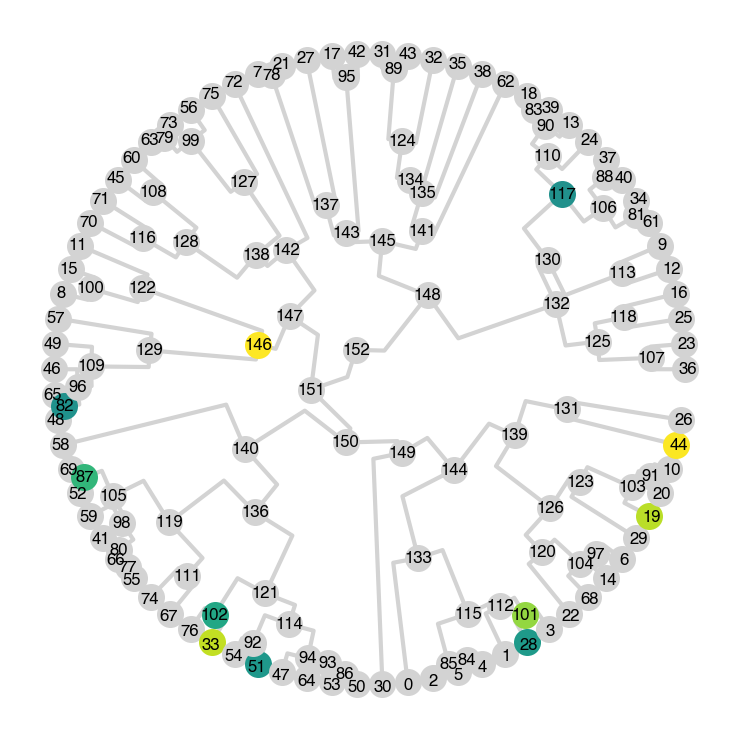

In [153]:
import matplotlib.transforms as mtransforms

fig = plt.figure(figsize=(3, 3), dpi=300)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[:, :], projection='polar')

trans_offset = mtransforms.offset_copy(ax.transData, fig=fig,
                                       y=6, units='dots')

plot_dendrogram_polar(
    linkage.reset_index(drop=True),
    linkage_label,
    dendro_kws=None,
    ax=ax,
    branch_type='straight',
    plot_node_id=True,
    plot_kws=dict(transform=trans_offset),
    node_hue=node_hue,
    node_hue_norm=(0, 2),
    palette='viridis',  # shared by both line and node hue
    node_size=None,
    node_size_norm=None,
    line_hue=None,
    line_hue_norm=None,
    sizes=None,
    size=30,
    linewidth=1,
    color=None)
ax.set_rlim(1.3, -0.1)
ax.axis('off')
pass

In [133]:
data[(data['Node'] == '119') & (data['log2odds'] < 0)]['Family'].value_counts(), data[(data['Node'] == '119') & \
                                                                                      (data['log2odds'] > 0)]['Family'].value_counts()

(SOX-related    12
 NF-1            3
 Name: Family, dtype: int64, Fos-related                      22
 Jun-related                      10
 B-ATF-related                     3
 Regulators of differentiation     2
 Maf-related                       1
 SMAD                              1
 CREB-related                      1
 Name: Family, dtype: int64)

In [155]:
node = '111'

related_tfs = set()
for gs in tf_class[tf_class['Family'].isin(data[(data['Node'] == node)]['Family'].unique())]['EnsemblID']:
    if isinstance(gs, float):
        continue
    for g in gs.split(','):
        related_tfs.add(g)
related_tfs = pd.Index(related_tfs)

genes = gene_assignment.loc[int(node)]
genes = genes[genes.abs() > 0.5]
mch_genes = genes.index.map(lambda i: i.split('.')[0])
related_tfs = related_tfs & mch_genes
related_tfs

Index([], dtype='object')

In [156]:
gene_meta.loc[[idbase_to_id[g] for g in related_tfs]]['gene_name']

Series([], Name: gene_name, dtype: object)

In [149]:
data[(data['Node'] == node)]['SubFamily'].value_counts()

Fos          10
TWIST         5
RFX           5
Kr-like       5
PAR           4
             ..
Small MAF     1
LHX1-like     1
PAX3-like     1
NRF           1
              1
Name: SubFamily, Length: 64, dtype: int64

In [150]:
tf_class[tf_class['EnsemblID'].fillna('').map(lambda i: any([(g in related_tfs) for g in i.split(',')]))]

,uid,GeneRawName,SuperClass,Class,Family,SubFamily,EnsemblID
54,1.2.1.0.2,TCF4 / SEF2,Basic domains,Basic helix-loop-helix factors (bHLH),E2A,E2A-like,"ENSMUSG00000017950,ENSMUSG00000053477,ENSMUSG0..."
543,2.3.3.74.1,ZNF442,Zinc-coordinating DNA-binding domains,C2H2 zinc finger factors,More than 3 adjacent zinc fingers,ZNF442-like,"ENSMUSG00000078886,ENSMUSG00000078897,ENSMUSG0..."
